In [3]:
import sys
import os
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
import scipy

import refnx
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

import refellips
from refellips.dataSE import DataSE, open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.dispersion import Cauchy, load_material, RI

In [1]:
file_path = r"C:\Users\lb958\Data\2023_01_09_Cu_after_2weeks\maps\Cu_Tile_longbreak_run01_20230109-171343.ds.dat"

In [4]:
data = DataSE(data=file_path)

ValueError: could not convert string 'Cu_Tile_longbreak_run01_20230109-171343_001.png' to float64 at row 0, column 6.

In [9]:
si = load_material("silicon")
sio2 = RI([1.4563, 0])
PNIPAM = Cauchy(1.47, 0.00495)
air = RI(pjoin(pth, "materials/air.csv"))

In [10]:
# this is a 20 Angstrom layer
# these are slab objects
silica_layer = sio2(20)

polymer_layer = PNIPAM(200)

In [11]:
silica_layer.name = "Silica"
silica_layer.thick.setp(vary=True, bounds=(1, 30))
silica_layer.vfsolv.setp(vary=False, value=0) #volume frac solvent

polymer_layer.name = "PNIPAM"
polymer_layer.thick.setp(vary=True, bounds=(100, 500))
polymer_layer.vfsolv.setp(vary=False, value=0)

In [12]:
structure = air() | polymer_layer | silica_layer | si()

In [14]:
model = ReflectModelSE(structure)

model.delta_offset.setp(value=0, vary=False, bounds=(-10, 10))



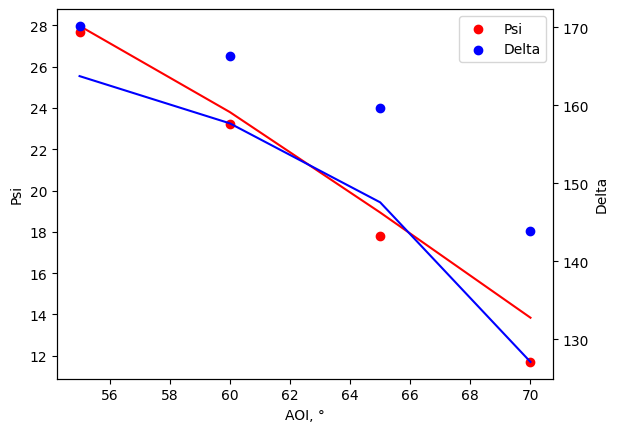

In [21]:
fig, ax = plt.subplots()
axt = ax.twinx()

aois = np.linspace(50, 75, 100)

for dat in data.unique_wavelength_data():
    wavelength, aois, psi_d, delta_d = dat
    wavelength_aois = np.c_[np.ones_like(aois) * wavelength, aois]

    psi, delta = model(wavelength_aois)
    ax.plot(aois, psi, color="r")
    p = ax.scatter(data.aoi, data.psi, color="r")

    axt.plot(aois, delta, color="b")
    d = axt.scatter(data.aoi, data.delta, color="b")

ax.legend(handles=[p, d], labels=["Psi", "Delta"])
ax.set(ylabel="Psi", xlabel="AOI, °")
axt.set(ylabel="Delta")
plt.show()

In [22]:
objective = ObjectiveSE(model, data)

In [23]:
fitter = CurveFitter(objective)
fitter.fit(method="differential_evolution")

You must install the tqdm library to use progress indicators with emcee


 message: Optimization terminated successfully.
 success: True
     fun: 0.09055641534106454
       x: [ 1.323e+02  1.000e+00]
     nit: 16
    nfev: 549
     jac: [-4.424e-06  5.703e-05]
   covar: [[ 9.652e+05 -9.891e+05]
           [-9.891e+05  1.014e+06]]
  stderr: [ 9.825e+02  1.007e+03]

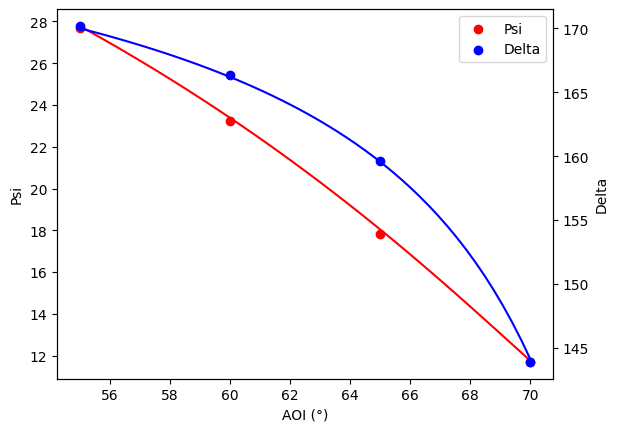

In [24]:
fig, ax = objective.plot()

In [25]:
for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0 (fixed)  , bounds=[-10.0, 10.0]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:    'PNIPAM'    
<Parameter:  ' - thick'   , value=132.339  +/- 982 , bounds=[100.0, 500.0]>
<Parameter: ' - cauchy A' , value=1.47 (fixed)  , bounds=[-inf, inf]>
<Parameter: ' - cauchy B' , value=0.00495 (fixed)  , bounds=[-inf, inf]>
<Parameter: ' - cauchy C' , value=0 (fixed)  , bounds=[-inf, in